 ## Tacotron 2 inference code
 Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

 #### Import libraries and setup matplotlib

In [18]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                    interpolation='none')
# %% [markdown]



In [19]:
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###

import matplotlib
import warnings
warnings.filterwarnings('ignore')

#matplotlib inline
import matplotlib.pylab as plt
## for compute y 
from data_utils import TextMelLoader, TextMelCollate
from torch.utils.data import DataLoader

import multiprocessing
multiprocessing.set_start_method('spawn', True)



import IPython.display as ipd
import os 
#os.chdir('/research/crissp/lebbat/NVIDIA-official/tacotron2/')
print(os.getcwd())
import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from waveglow.denoiser import Denoiser
import random
#import audio
import tensorflow as tf
##
import stft 


#torch.manual_seed(0)



/media/lebbat/NFV/lebbat/NVIDIA-official/tacotron2_gricad


In [20]:
def split_title_line(title_text, max_words=10):
    """
    A function that splits any string based on specific character
    (returning it with the string), with maximum number of words on it
    """
    seq = title_text.split()
    return '\n'.join([' '.join(seq[i:i + max_words]) for i in range(0, len(seq), max_words)])
    # %% [markdown]


In [21]:
def plot_alignment(alignment, path, title=None, split_title=False, max_len=None):
    if max_len is not None:
        alignment = alignment[:, :max_len]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    im = ax.imshow(
        alignment,
        aspect='auto',
        origin='lower', 
        interpolation='none')
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'

    if split_title:
        title = split_title_line(title)

    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    plt.savefig(path, format='png')
    # To NOT SHOW
    plt.close()

    #%% [markdown]


In [22]:
def plot_wave(predicted_wave, path=None, title=None, split_title=False, target_wave=None, max_len=None, auto_aspect=False):
    if max_len is not None:
        target_wave = target_wave[:max_len]
        predicted_wave = predicted_wave[:max_len]
    fig, ax = plt.subplots(figsize=(20, 8))
        #fig = plt.figure(figsize=(8, 6)) # it was(10, 8)
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    center = left + width/2
    # Set common labels
    # set title 
    if title is not None:
        if split_title:
            title = split_title_line(title) 
        fig.text(center, top,title, horizontalalignment='center',verticalalignment='center', fontsize=16)
        
    #plt.figure()
    plt.plot(predicted_wave)

    if path is not None :
        plt.savefig(path, format='png')
        # To NOT SHOW
    plt.close()

In [23]:
def plot_spectrogram(pred_spectrogram, path=None, title=None, split_title=False, target_spectrogram=None, max_len=None, auto_aspect=False):
    if max_len is not None:
        target_spectrogram = target_spectrogram[:max_len]
        pred_spectrogram = pred_spectrogram[:max_len]

    if split_title:
        title = split_title_line(title)

    fig = plt.figure(figsize=(8, 6)) # it was(10, 8)
    # Set common labels
    fig.text(0.5, 0.18, title, horizontalalignment='center', fontsize=16)

    #target spectrogram subplot
    if target_spectrogram is not None:
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)

        if auto_aspect:
            im = ax1.imshow(np.rot90(target_spectrogram), aspect='auto', interpolation='none')
        else:
            im = ax1.imshow(np.rot90(target_spectrogram), interpolation='none')
        ax1.set_title('Target Mel-Spectrogram')
        fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
        ax2.set_title('Predicted Mel-Spectrogram')
    else:
        ax2 = fig.add_subplot(211) # it was add_subplot(211)

    if auto_aspect:
        im = ax2.imshow(np.rot90(pred_spectrogram), aspect='auto', interpolation='none')
    else:
        im = ax2.imshow(pred_spectrogram, aspect='auto', origin='bottom', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax2)

    plt.tight_layout()
#     if path is not None :
#         plt.savefig(path, format='png')
#         # To NOT SHOW
#         plt.close()




In [24]:
def plot_gate_outputs_to_numpy(gate_outputs,path=None, title=None, split_title=False):
    fig, ax = plt.subplots(figsize=(12, 3))
        #fig = plt.figure(figsize=(8, 6)) # it was(10, 8)
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    center = left + width/2
    # Set common labels
    # set title 
    if title is not None:
        if split_title:
            title = split_title_line(title) 
        fig.text(center, top,title, horizontalalignment='center',verticalalignment='center', fontsize=16)
    #ax.scatter(range(len(gate_targets)), gate_targets, alpha=0.7,
            #color='green', marker='+', s=3, label='target')
    ax.scatter(range(len(gate_outputs)), gate_outputs, alpha=1,
            color='red', marker='.', s=10, label='predicted')

    plt.xlabel("Frames ( Red predicted)")
    plt.ylabel("Gate State")
    plt.tight_layout()

    fig.canvas.draw()
    
    if path is not None :
        plt.savefig(path, format='png')
        # To NOT SHOW
        plt.close()
    #plt.show()    
    

# %% [markdown]
# #### Setup hparams


In [25]:
hparams = create_hparams()
hparams.max_decoder_steps=2000
hparams.sampling_rate = 22050
hparams.batch_size = 2
hparams.training_files = 'FR-fr_Our/test_text'
data_name = hparams.training_files.strip().split('/')
data_name =data_name[-1]

# %% [markdown]
# #### Load model from checkpoint


In [58]:
#checkpoint_path = "/research/crissp/lebbat/Tacotron_Synthesis/Tacotron-2-master/Tacotron-2-master/logs-Tacotron-2/taco_pretrained/100k/tacotron_model.ckpt-100000.data-00000-of-00001"
checkpoint_path = "./checkpoint_99000_idris"
#checkpoint_path = "/research/crissp/lebbat/NVIDIA-official/tacotron2_gpu2/checkpoint_99000_idris"
#checkpoint_path = "/research/crissp/lebbat/NVIDIA-official/tacotron2_gpu2/out/checkpoint_190000"
#checkpoint_path = "checkpoint_16000"
#checkpoint_path = "tacotron2_statedict.pt"
checkpoint_name = checkpoint_path.strip().split('/')
checkpoint_name = checkpoint_name[-1]
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#random.seed(0)
#np.random.seed(0)
# train_dir = os.path.join(os.getcwd(), 'train-eval_'+ checkpoint_name + data_name)
# val_dir = os.path.join(os.getcwd(), 'val-eval_'+ checkpoint_name + data_name)
# test_dir = os.path.join(os.getcwd(), 'test-eval_'+ checkpoint_name + data_name)
# difficile_dir = os.path.join(os.getcwd(), 'difficile-eval_'+ checkpoint_name + data_name)

# plot_train_dir = os.path.join(train_dir, 'plots')
# plot_val_dir = os.path.join(val_dir, 'plots')
# plot_test_dir = os.path.join(test_dir, 'plots')
# plot_difficile_dir = os.path.join(difficile_dir, 'plots')

# wav_dir_sTrain = os.path.join(train_dir, 'wavs')
# wav_dir_sVal = os.path.join(val_dir, 'wavs')
# wav_dir_sTest = os.path.join(test_dir, 'wavs')
# wav_dir_difficile = os.path.join(difficile_dir, 'wavs')


# os.makedirs(plot_train_dir, exist_ok=True)
# os.makedirs(plot_val_dir, exist_ok=True)
# os.makedirs(plot_test_dir, exist_ok=True)
# os.makedirs(plot_difficile_dir, exist_ok=True)

# os.makedirs(wav_dir_sTrain, exist_ok=True)
# os.makedirs(wav_dir_sVal, exist_ok=True)
# os.makedirs(wav_dir_sTest, exist_ok=True)
# os.makedirs(wav_dir_difficile, exist_ok=True)

ponctuation_dir = os.path.join(os.getcwd(), 'ponctuation-eval_'+ checkpoint_name + data_name)
plot_ponctiation_dir = os.path.join(ponctuation_dir, 'plots')
wav_dir_ponctiation = os.path.join(ponctuation_dir, 'wavs')

# os.makedirs(ponctuation_dir, exist_ok=True)
# os.makedirs(plot_ponctiation_dir, exist_ok=True)
# os.makedirs(wav_dir_ponctiation, exist_ok=True)

holy cow


#### %% [markdown]
#### Load WaveGlow for mel2audio synthesis and denoiser





In [27]:
waveglow_path = 'waveglow_256channels_ljs_v2_new.pt'
#waveglow_path = 'waveglow/checkpoints/waveglow_50000'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)


In [28]:
def prepare_dataloaders(hparams):
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    train_loader = DataLoader(trainset, num_workers=1, shuffle=False,
                            sampler=None,
                            batch_size=hparams.batch_size, pin_memory=False,
                            drop_last=False, collate_fn=collate_fn)
    return train_loader, valset, collate_fn



In [29]:
from scipy.io import wavfile
def save_wav(wav, path, sr):
	wav *= 32767 / max(0.01, np.max(np.abs(wav)))
	#proposed by @dsmiller
	wavfile.write(path, sr, wav.astype(np.int16))

In [30]:
ponctuations = ['!', '\"',  '(',  ')',  ',',  '.',  ':', ';', '?', '«', '»', '—', '…', '-', '[', ']']
len(ponctuations)

16

In [31]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin, hparams.mel_fmax)
stft_fn = STFT(hparams.filter_length, hparams.hop_length, hparams.win_length)

In [39]:
def dtwPlotThreeWay_BL(d=None, xts=None, yts=None,title=None,path=None, split_title=False,
                    match_indices=None,
                    match_col="gray",
                    xlab="Query index",
                    ylab="Reference index", **kwargs):
    # IMPORT_RDOCSTRING dtwPlotThreeWay
    
    # ENDIMPORT
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from matplotlib import collections  as mc
    


    if xts is None or yts is None:
        try:
            xts = d.query
            yts = d.reference
        except:
            raise ValueError("Original timeseries are required")

    nn = len(xts)
    mm = len(yts)
    nn1 = np.arange(nn)
    mm1 = np.arange(mm)

    fig = plt.figure()
    
#         #BL:added 
#     if split_title is not None:
#         title = split_title_line(title)
#     plt.suptitle(title)
    
   
        
    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[1, 3],
                           height_ratios=[3, 1])
    axr = plt.subplot(gs[0])
    ax = plt.subplot(gs[1])
    axq = plt.subplot(gs[3])

    axq.plot(nn1, xts)  # query, horizontal, bottom
    axq.set_xlabel(xlab)

    axr.plot(yts, mm1)  # ref, vertical
    axr.invert_xaxis()
    axr.set_ylabel(ylab)

    ax.plot(d.index1, d.index2)

    if match_indices is None:
        idx = []
    elif not hasattr(match_indices, "__len__"):
        idx = np.linspace(0, len(d.index1) - 1, num=match_indices)
    else:
        idx = match_indices
    idx = np.array(idx).astype(int)

    col = []
    for i in idx:
        col.append([(d.index1[i], 0),
                    (d.index1[i], d.index2[i])])
        col.append([(0, d.index2[i]),
                    (d.index1[i], d.index2[i])])

    lc = mc.LineCollection(col, linewidths=1, linestyles=":", colors=match_col)
    ax.add_collection(lc)
    

    fig.canvas.draw()
    ponctuations
    #if path is not None :
        #plt.savefig(path, format='png')
        # To NOT SHOW
        #plt.close()

    #plt.show()
    #return ax

zozozozozzo
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 12), (15, 13), (16, 13), (17, 14), (18, 15), (19, 16), (20, 17), (21, 18), (22, 19), (23, 20), (24, 21), (25, 22), (26, 23), (27, 24), (28, 25), (29, 26), (30, 27), (31, 28), (32, 29), (33, 30), (34, 31), (35, 32), (36, 33), (37, 34), (38, 35), (39, 36), (40, 37), (41, 38), (42, 39), (43, 40), (44, 41), (45, 42), (46, 43), (47, 43), (48, 44), (49, 45), (50, 46), (51, 47), (52, 47), (53, 47), (54, 47), (55, 47), (56, 47), (57, 47), (58, 47), (59, 47), (60, 47), (61, 47), (62, 47), (63, 47), (64, 47), (65, 47), (66, 47), (67, 47), (68, 47), (69, 48), (70, 49), (71, 50), (72, 51), (73, 52), (74, 53), (75, 54), (76, 55), (77, 56), (78, 57), (79, 58), (80, 59), (81, 60), (82, 61), (83, 62), (84, 63), (85, 64), (86, 65), (87, 66), (88, 67), (89, 68), (90, 69), (91, 70), (92, 71), (93, 72), (94, 73), (95, 74), (96, 75), (97, 76), (98, 77), (99, 78), (100, 78

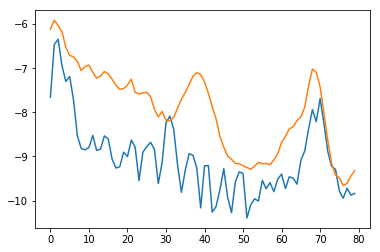

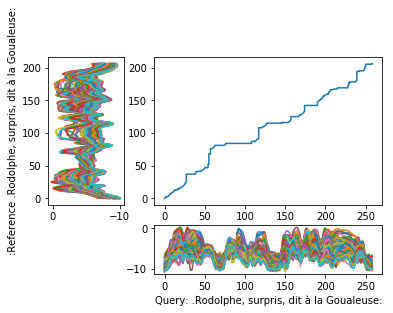

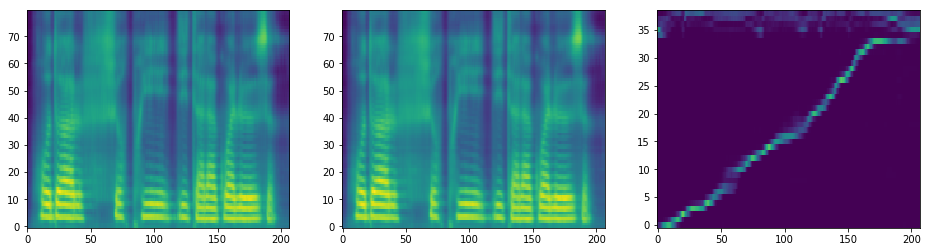

In [56]:
from dtw import *
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


def get_dtw(hparams):
    with open(hparams.training_files, encoding="utf-8") as f:
        matrix = []
        #for line in f:
        line = 'FR-fr_Our/_wav_utt_22050/ES_LMP_NEB_01_0010_55|.Rodolphe, surpris, dit à la Goualeuse:|.Rodolphe, surpris, dit à la Goualeuse:'
        # create original matrix
        original = []
        parts = line.strip().split('|')
        #get the text part easy
        text_original = parts[1]
        #replace the first character 'ponctuation' by the one the list
        #for ponctuation in ponctuations:
            # create punctuation matrix
        ponctuation = '.'
        stext = list(text_original)
        # take the first ponctuation
        stext[0] = ponctuation
        #punctuationM.append(ponctuation)
        text = "".join(stext)
        #get the FR-fr_Our/_wav_utt/ES_LMP_NEB_02_0011_19 part which is parts[0]
        text_Npath =  parts[0].strip().split('/')
        #take the last part S_LMP_NEB_02_0011_19
        basename = text_Npath[-1]
        mel_original = np.load('./mels/mel-{}.npy'.format(basename))
        sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
        sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(sequence,hparams)
        _dir=ponctuation_dir
        # plot spectrogram
#         plot_spectrogram(mel_outputs_postnet.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-post-{}-{}.png'.format(basename,"".join(text[0:100]))),
#             title='mel postnet \r \n {}'.format(text), split_title=True)  
#         plot_spectrogram(mel_original, os.path.join(_dir, 'plots/mel-post-{}-{}.png'.format(basename,"".join(text[0:100]))),
#             title='mel postnet \r \n {}'.format(text), split_title=True)  
        #print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

        #save alignments
#                 plot_alignment(alignments.float().data.cpu().numpy()[0].T, os.path.join(_dir, 'plots/alignment-{}-{}.png'.format(basename,"".join(text[0:100]))),
#                     title='{}'.format(text), split_title=True)
        #save gates 
#                 idx = random.randint(0, alignments.size(0) - 1)
#                 plot_gate_outputs_to_numpy(
#                     torch.sigmoid(gate_outputs[idx]).data.cpu().numpy(), os.path.join(_dir, 'plots/gate-{}.png'.format(basename)),
#                     title='{}'.format(text), split_title=True)
        #generate audio
#         with torch.no_grad():
#             audio = waveglow.infer(mel_original.T, sigma=0.6)
#             audio_denoised = denoiser(audio, strength=0.05)[:, 0]
#             ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
#             audio_waveglow= audio_denoised.cpu().numpy()
        #print(len(mel_outputs_postnet.float().data.cpu().numpy()[0][1]))
        #generate plot audio
        #plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
        #    title='audio_denoised \r \n {}'.format(text), split_title=True)
        #save audio
        #save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-wavegElow-ljs-{}-.wav'.format(split_title_line(text[-50:-1], max_words=1))), sr=22050)
        #generate plot audio
#                 plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}-{}.png'.format(basename,"".join(text[0:100]))),
#                     title='audio_denoised \r \n {}'.format(text), split_title=True)
#                 #save audio
#                 save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-waveglow-ljs-{}-.wav'.format(basename,"".join(text[0:100]))), sr=hparams.sampling_rate)     
#                 inverse_transform = stft.mel_inv_spectrogram(mel_outputs_postnet.float().data.cpu())
#                 audio_grif =griffin_lim(inverse_transform,stft_fn)
#                 save_wav(audio_grif[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-griffin-{}-.wav'.format(basename,"".join(text[0:100]))), sr=hparams.sampling_rate)

        #distance, path = fastdtw(mel_outputs_postnet.float().data.cpu().numpy()[0].T, mel_original.T, dist=euclidean)
        original_mel = mel_original.T
        query_mel = mel_outputs_postnet.float().data.cpu().numpy()[0].T
        #print("original shape {}".format(original_mel[0].shape))
        #print("query shape {}".format(query_mel[0].shape))
        if ponctuation == '.':
            fig = plt.figure()
            fig.canvas.draw()
            plt.plot(original_mel[254])
            plt.plot(query_mel[203])
        distance, path = fastdtw(original_mel,query_mel, dist=euclidean)
        norm_distance = distance / len(path)
        print(path)
        #plt.plot(path[0](0,0))
#         print("the path is : {}".format(path))
#         print('The fast DTW distance is {} between original {} and {} : '.format(norm_distance, text_original,text))
        original.append((text_original,ponctuation, norm_distance))
        alignment = dtw(original_mel,query_mel, keep_internals=True)
        #plt.suptitle('Categorical Plotting')
        dtwPlotThreeWay_BL(alignment,path = os.path.join(_dir, 'plots/DTW-{}-{}.png'.format(basename,"".join(text[0:100]))),
            xlab='Query: {}'.format(text), ylab=':Reference {}'.format(text_original), split_title=True)
#             original.append(punctuationM)
#             matrix.append(original)  
            #plt.suptitle('Categorical Plotting')
            ## Display the warping curve, i.e. the alignment curve
#                 alignment.plot(type="threeway",title='The fast DTW distance is {} between original {} and {} : '.format(distance, text_original,text))
#  

#                 ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
#                 dtw(alignment, keep_internals=True, 
#                     step_pattern=rabinerJuangStepPattern(6, "c"))\
#                     .plot(type="twoway",offset=-2)

#                 ## See the recursion relation, as formula and diagram
#                 print(rabinerJuangStepPattern(6,"c"))
#                 rabinerJuangStepPattern(6,"c").plot()
        #file.close()
        plot_data((mel_outputs.float().data.cpu().numpy()[0],
            mel_outputs_postnet.float().data.cpu().numpy()[0],
            alignments.float().data.cpu().numpy()[0].T))

            #idx = random.randint(0, alignments.size(0) - 1)
            #plot_gate_outputs_to_numpy(
                #torch.sigmoid(gate_outputs[idx]).data.cpu().numpy())
    #return matrix
matrix = get_dtw(hparams)

# %% [markdown]

In [ ]:
from dtw import *
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


def get_dtw(hparams):
    with open(hparams.training_files, encoding="utf-8") as f:
        matrix = []
        for line in f:
            # create original matrix
            original = []
            parts = line.strip().split('|')
            #get the text part easy
            text_original = parts[1]
            #replace the first character 'ponctuation' by the one the list
            for ponctuation in ponctuations:
                # create punctuation matrix
                stext = list(text_original)
                # take the first ponctuation
                stext[0] = ponctuation
                #punctuationM.append(ponctuation)
                text = "".join(stext)
                #get the FR-fr_Our/_wav_utt/ES_LMP_NEB_02_0011_19 part which is parts[0]
                text_Npath =  parts[0].strip().split('/')
                #take the last part S_LMP_NEB_02_0011_19
                basename = text_Npath[-1]
                mel_original = np.load('./mels/mel-{}.npy'.format(basename))
                sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
                sequence = torch.autograd.Variable(
                torch.from_numpy(sequence)).cuda().long()
                mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(sequence,hparams)
                _dir=ponctuation_dir
                # plot spectrogram
#                 plot_spectrogram(mel_outputs_postnet.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-post-{}-{}.png'.format(basename,"".join(text[0:100]))),
#                     title='mel postnet \r \n {}'.format(text), split_title=True)  
                #print(mel_outputs_postnet.detach().cpu().numpy().shape[2])
                    
                #save alignments
#                 plot_alignment(alignments.float().data.cpu().numpy()[0].T, os.path.join(_dir, 'plots/alignment-{}-{}.png'.format(basename,"".join(text[0:100]))),
#                     title='{}'.format(text), split_title=True)
                #save gates 
#                 idx = random.randint(0, alignments.size(0) - 1)
#                 plot_gate_outputs_to_numpy(
#                     torch.sigmoid(gate_outputs[idx]).data.cpu().numpy(), os.path.join(_dir, 'plots/gate-{}.png'.format(basename)),
#                     title='{}'.format(text), split_title=True)
                #generate audio
#                 with torch.no_grad():
#                     audio = waveglow.infer(mel_outputs_postnet, sigma=0.6)
#                 ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
#                 #save audio
#                 audio_denoised = denoiser(audio, strength=0.05)[:, 0]
#                 ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
                #generate plot audio
#                 plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}-{}.png'.format(basename,"".join(text[0:100]))),
#                     title='audio_denoised \r \n {}'.format(text), split_title=True)
#                 #save audio
#                 save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-waveglow-ljs-{}-.wav'.format(basename,"".join(text[0:100]))), sr=hparams.sampling_rate)     
#                 inverse_transform = stft.mel_inv_spectrogram(mel_outputs_postnet.float().data.cpu())
#                 audio_grif =griffin_lim(inverse_transform,stft_fn)
#                 save_wav(audio_grif[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-griffin-{}-.wav'.format(basename,"".join(text[0:100]))), sr=hparams.sampling_rate)
                
                #distance, path = fastdtw(mel_outputs_postnet.float().data.cpu().numpy()[0].T, mel_original.T, dist=euclidean)
                original_mel = mel_original.T
                query_mel = mel_outputs_postnet.float().data.cpu().numpy()[0].T
                #print("original shape {}".format(original_mel[0].shape))
                #print("query shape {}".format(query_mel[0].shape))
                if ponctuation == '.':
                    plt.plot(original_mel[100])
                    plt.plot(query_mel[78])
                distance, path = fastdtw(original_mel,query_mel, dist=euclidean)
                norm_distance = distance / len(path)
                #print(path[:,:][0])
                #plt.plot(path[0](0,0))
                #print("the path is : {}".format(path))
                print('The fast DTW distance is {} between original {} and {} : '.format(norm_distance, text_original,text))
                original.append((text_original,ponctuation, norm_distance))
                alignment = dtw(original_mel,query_mel, keep_internals=True)
                #plt.suptitle('Categorical Plotting')
                dtwPlotThreeWay_BL(alignment,path = os.path.join(_dir, 'plots/DTW-{}-{}.png'.format(basename,"".join(text[0:100]))),
                    xlab='Query: {}'.format(text), ylab=':Reference {}'.format(text_original), split_title=True)
#             original.append(punctuationM)
            matrix.append(original)  
                #plt.suptitle('Categorical Plotting')
                ## Display the warping curve, i.e. the alignment curve
#                 alignment.plot(type="threeway",title='The fast DTW distance is {} between original {} and {} : '.format(distance, text_original,text))
#  

#                 ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
#                 dtw(alignment, keep_internals=True, 
#                     step_pattern=rabinerJuangStepPattern(6, "c"))\
#                     .plot(type="twoway",offset=-2)

#         e tu as vraiment eu ton doctorat! Mais 3laach! ! Ma dihach fihoum tt simplement! Nta insan najeh w ila jiti à chaque fois tred 3la lm7         ## See the recursion relation, as formula and diagram
#                 print(rabinerJuangStepPattern(6,"c"))
#                 rabinerJuangStepPattern(6,"c").plot()
            #file.close()
                #plot_data((mel_outputs.float().data.cpu().numpy()[0],
                    #mel_outputs_postnet.float().data.cpu().numpy()[0],
                    #alignments.float().data.cpu().numpy()[0].T))

                #idx = random.randint(0, alignments.size(0) - 1)
                #plot_gate_outputs_to_numpy(
                    #torch.sigmoid(gate_outputs[idx]).data.cpu().numpy())
    return matrix
matrix = get_dtw(hparams)

# %% [markdown]

In [ ]:
import pandas as pd
#np.array(matrix).dump(open('Matrix_'+data_name+'.npy', 'wb'))
print(matrix[1][15])
#print(len(matrix[1]))

mean=[]
for ponctuation in ponctuations:
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j][0][0] == ponctuation:
                #p_mean=[]
                for ponctuation_predict in ponctuations:
                    if matrix[i][j][1] == ponctuation_predict:
                        #print("original: {}, predicted: {}, dist: {} ".format(ponctuation, matrix[i][j][1],matrix[i][j][2]))
                        mean.append((ponctuation, matrix[i][j][1],matrix[i][j][2]))
                #mean.append(p_mean)
#mean
df = pd.DataFrame(mean,columns =['Original', 'Predict', 'Score'])
#print(df)
mean=df.groupby(['Original', 'Predict'], as_index=False).mean()

df.to_csv('export_dataframe.csv', index = False, header=True)

mean.to_csv('export_mean_punctuation.csv', index = False, header=True)




mtr = mean.pivot(index='Predict',columns='Original',values='Score')
mtr.to_csv('export_Matrix_DTW.csv', index = False, header=True)
mtr
#mtr = pd.DataFrame(mtr,columns=[])
#g = mean.groupby("Original")
#mean.iloc[:,[2]]
#pd.concat((mean['Original'], pd.DataFrame(arr, columns=mean['Predict'])), axis=1)

#.groupby('Original')['Score'].mean()



            



#import csv

# with open("Matrix_"+data_name+".csv", 'w+', newline='', encoding="utf-8") as myfile:
#     wr = csv.writer(myfile,delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     wr.writerow(ponctuations)
#     wr.writerow(matrix)

# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###

In [ ]:
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# train_loader, valset, collate_fn = prepare_dataloaders(hparams)
# fodelimiter=' 'r i, batch in enumerate(train_loader):
#     x, y = model.parse_batch(batch)
#     y_pred = model(x)
#     #print(batch)
#     #print(y)
#     #print(x)

In [ ]:
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
def get_sentence(hparams):
    with open(hparams.training_files, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split('|')
            #get the text part easy
            text = parts[1]
            
            #get the FR-fr_Our/_wav_utt/ES_LMP_NEB_02_0011_19 part which is parts[0]
            text_Npath =  parts[0].strip().split('/')
            #take the last part S_LMP_NEB_02_0011_19
            basename = text_Npath[-1]
            sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
            #print(text) 
            sequence = torch.autograd.Variable(
            torch.from_numpy(sequence)).cuda().long()
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(sequence,hparams)
            #CB-BL: by me save the original duration
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            file = open('predicted_duration_difficile.txt', "a+", encoding="utf-8")
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            _dir=difficile_dir
            ###***CHANGE Name***###
            mel_outputs_postnet_np = mel_outputs_postnet.detach().cpu().numpy()
            file.write(str(mel_outputs_postnet_np.shape[2]) + "\n")
            #save mel spectrogram plot
            plot_spectrogram(mel_outputs.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-{}.png'.format(basename)),
                title='{}'.format(text), split_title=True)  
            #save mel_outputs_postnet plot
            plot_spectrogram(mel_outputs_postnet.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-post-{}.png'.format(basename)),
                title='mel postnet \r \n {}'.format(text), split_title=True)  
            print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

            #save alignments
            plot_alignment(alignments.float().data.cpu().numpy()[0].T, os.path.join(_dir, 'plots/alignment-{}.png'.format(basename)),
                title='{}'.format(text), split_title=True)
            #save gates 
            idx = random.randint(0, alignments.size(0) - 1)
            plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy(), os.path.join(_dir, 'plots/gate-{}.png'.format(basename)),
                title='{}'.format(text), split_title=True)
            #generate audio
            with torch.no_grad():
                audio = waveglow.infer(mel_outputs_postnet, sigma=0.6)
            ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
            #save audio
            audio_denoised = denoiser(audio, strength=0.05)[:, 0]
            ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
            #generate plot audio
            plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}.png'.format(basename)),
                title='audio_denoised \r \n {}'.format(text), split_title=True)
            #save audio
            save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-waveglow-ljs-{}-.wav'.format(basename,split_title_line(text[-50:-1], max_words=1))), sr=22050)     
            inverse_transform = stft.mel_inv_spectrogram(mel_outputs_postnet.float().data.cpu())
            audio =griffin_lim(inverse_transform,stft_fn)
            save_wav(audio[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-griffin-{}-.wav'.format(basename,split_title_line(text[-50:-1], max_words=1))), sr=hparams.sampling_rate)
        file.close()
            #plot_data((mel_outputs.float().data.cpu().numpy()[0],
                #mel_outputs_postnet.float().data.cpu().numpy()[0],
                #alignments.float().data.cpu().numpy()[0].T))
                
            #idx = random.randint(0, alignments.size(0) - 1)
            #plot_gate_outputs_to_numpy(
                #torch.sigmoid(gate_outputs[idx]).data.cpu().numpy())
    return mel_outputs_postnet
get_sentence(hparams)
# %% [markdown]

In [ ]:
def plot_bis(state):
    X, Y = [], []
    #for line in open('original_duration_{}_{}_{}.txt'.format(state,data,checkpoint_name)):
    for line in open('original_duration.txt'):
      values = [float(s) for s in line.split()]
      X.append(values[0])
    #for line in open('predicted_duration_{}_{}_{}.txt'.format(state,'Y_train_Shape_11121_2020-02-03 17.25.48.002',checkpoint_name)):
    for line in open('predicted_duration_{}.txt'.format('Y_valid_Shape_586_2020-02-03 17.25.48.074_16000')):
      values = [float(s) for s in line.split()]
      Y.append(values[0])
    fig = plt.figure(figsize=(16, 10))
    plt.xlabel("Original number of mel-frames for "+ state + "data"+" iteration "+ checkpoint_name)
    plt.ylabel("predicted number of mel-frames for "+ state + " data"+" iteration "+ checkpoint_name)
    plt.tight_layout()
    ###***CHANGE Name***###
    basename = 'mel-frame_{}_{}'.format(state,checkpoint_name)
    fig.canvas.draw()
    ###***CHANGE Color***###

    if state == "train": 
        plt.plot(X, Y,'ro')
        plt.savefig(os.path.join(plot_test_dir,'comparaison-{}.png'.format(basename)), format='png')
        plt.close()
    elif state == "valid":
        plt.plot(X, Y,'bo')
        plt.savefig(os.path.join(plot_test_dir,'comparaison-{}.png'.format(basename)), format='png')
        plt.close()
    elif state == "test": 
        plt.plot(X, Y,'go')
        plt.savefig(os.path.join(plot_test_dir,'comparaison-{}.png'.format(basename)), format='png')
        plt.close()


##***CHANGE Name***###
plot_bis("valid")




In [ ]:

def save_wav(wav, path, sr):
	wav *= 32767 / max(0.01, np.max(np.abs(wav)))
	#proposed by @dsmiller
	wavfile.write(path, sr, wav.astype(np.int16))

In [ ]:

def inv_mel_spectrogram_tensorflow(mel_spectrogram, hparams):
	'''Builds computational graph to convert mel spectrogram to waveform using TensorFlow.
	Unlike inv_mel_spectrogram, this does NOT invert the preemphasis. The caller should call
	inv_preemphasis on the output after running the graph.
	'''
	if hparams.signal_normalization:
		D = _denormalize_tensorflow(mel_spectrogram, hparams)
		
	else:
		D = mel_spectrogram

	S = tf.pow(_db_to_amp_tensorflow(D + hparams.ref_level_db), (1/hparams.magnitude_power))
	#print(S.shape)
	S = _mel_to_linear_tensorflow(S, hparams)  # Convert back to linear
	print(S.shape)
	return _griffin_lim_tensorflow(tf.pow(S, hparams.power), hparams)

In [71]:
text = ".Bonjour Hello group members I have this straight line graph."
#text = ".Bonjour, je m'appelle badreddine."
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()



In [ ]:
text2 = ".!je m'appelle ."
sequence2 = np.array(text_to_sequence(text2, ['transliteration_cleaners']))[None, :]
sequence2 = torch.autograd.Variable(
    torch.from_numpy(sequence2)).cuda().long()



In [ ]:
text3 = ";je m'appelle ;"
sequence3 = np.array(text_to_sequence(text3, ['transliteration_cleaners']))[None, :]
sequence3 = torch.autograd.Variable(
    torch.from_numpy(sequence3)).cuda().long()



In [ ]:
text4 = "-Bonjour Tacotron ..."
sequence4 = np.array(text_to_sequence(text4, ['transliteration_cleaners']))[None, :]
sequence4 = torch.autograd.Variable(
    torch.from_numpy(sequence4)).cuda().long()

# %% [markdown]
# #### Decode text input and plot results


zozozozozzo
317


array([-10.1796875 ,  -9.9375    ,  -9.9609375 ,  -9.8359375 ,
        -9.71875   ,  -9.6328125 ,  -9.6328125 ,  -9.5       ,
        -9.2890625 ,  -9.1328125 ,  -9.015625  ,  -8.75      ,
        -8.5390625 ,  -8.3515625 ,  -8.0703125 ,  -7.40625   ,
        -6.99609375,  -7.0546875 ,  -7.234375  ,  -7.2109375 ,
        -7.21875   ,  -7.33203125,  -7.4296875 ,  -7.5625    ,
        -7.5625    ,  -7.45703125,  -7.19140625,  -6.70703125,
        -6.43359375,  -6.36328125,  -6.2890625 ,  -6.1015625 ,
        -6.25390625,  -6.73828125,  -7.06640625,  -7.39453125,
        -7.53515625,  -7.46484375,  -7.46875   ,  -7.546875  ,
        -7.54296875,  -7.46484375,  -7.3984375 ,  -7.359375  ,
        -7.2890625 ,  -7.2578125 ,  -7.078125  ,  -6.8203125 ,
        -6.59765625,  -6.47265625,  -6.37109375,  -6.40234375,
        -6.50390625,  -6.56640625,  -6.59765625,  -6.75      ,
        -6.85546875,  -6.90625   ,  -6.93359375,  -7.02734375,
        -7.078125  ,  -7.11328125,  -7.1484375 ,  -7.26

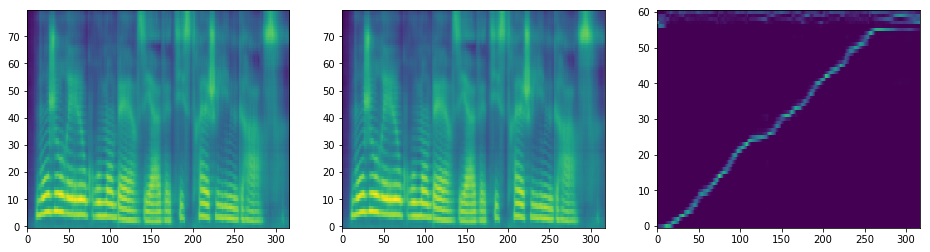

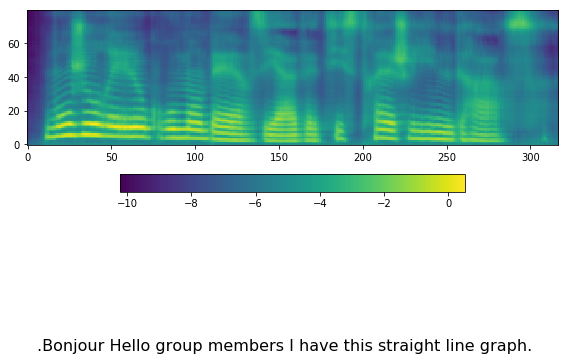

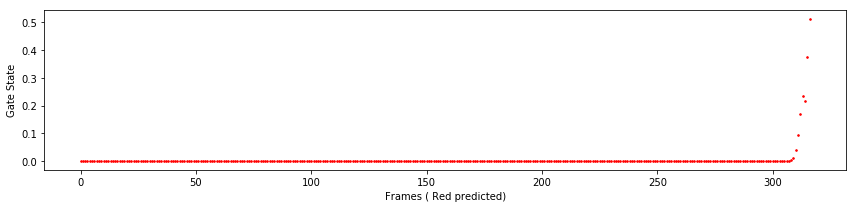

In [72]:
mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(sequence,hparams)

plot_data((mel_outputs.float().data.cpu().numpy()[0],
        mel_outputs_postnet.float().data.cpu().numpy()[0],
        alignments.float().data.cpu().numpy()[0].T))

plot_spectrogram(mel_outputs.float().data.cpu().numpy()[0],title='{}'.format(text), split_title=True) 

print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

    
idx = random.randint(0, alignments.size(0) - 1)

plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'

mel_outputs_postnet.detach().cpu().numpy()[0,79]



In [61]:
#save mel spectrogram plot
_dir='/home/lebbatb-admin/Images'
plot_spectrogram(mel_outputs.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='{}'.format(text), split_title=True)  
#save mel_outputs_postnet plot
plot_spectrogram(mel_outputs_postnet.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-post-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='mel postnet \r \n {}'.format(text), split_title=True)  
#print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

#save alignments
plot_alignment(alignments.float().data.cpu().numpy()[0].T, os.path.join(_dir, 'plots/alignment-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='{}'.format(text), split_title=True)
#save gates 
idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
    torch.sigmoid(gate_outputs[idx]).data.cpu().numpy(), os.path.join(_dir, 'plots/gate-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='{}'.format(text), split_title=True)
# generate audio
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.6)
    audio_denoised = denoiser(audio, strength=0.05)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
audio_waveglow= audio_denoised.cpu().numpy()
#print(len(mel_outputs_postnet.float().data.cpu().numpy()[0][1]))
#generate plot audio
#plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
#    title='audio_denoised \r \n {}'.format(text), split_title=True)
#save audio
save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-waveglow-ljs-{}-.wav'.format(split_title_line(text[-50:-1], max_words=1))), sr=22050)

NameError: name 'mel_outputs' is not defined

In [ ]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin, hparams.mel_fmax)
stft_fn = STFT(hparams.filter_length, hparams.hop_length, hparams.win_length)

In [ ]:
#audio = inv(mel_outputs_postnet.float().T.data.cpu().numpy()[:,:,0])
inverse_transform = stft.mel_inv_spectrogram(mel_outputs_postnet.float().data.cpu())
audio =griffin_lim(inverse_transform,stft_fn)

ipd.Audio(audio.data.cpu().numpy(), rate=22050)
#audio_grif = audio.data.cpu().numpy()


#print(len(audio_grif[0]))
#save_wav(audio[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-griffin-{}-.wav'.format(split_title_line(text[-50:-1], max_words=1))), sr=hparams.sampling_rate)


In [ ]:
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path = fastdtw(mel_outputs_postnet.float().data.cpu().numpy()[0], mel_outputs.float().data.cpu().numpy()[0], dist=euclidean)
print(distance)

In [ ]:
from dtw import *
## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

## Find the best match with the canonical recursion formulaaudio_grif[0].ravel()
from dtw import *
alignment = dtw(mel_outputs_postnet.float().data.cpu().numpy()[0].T, mel_outputs.float().data.cpu().numpy()[0].T, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(mel_outputs_postnet.float().data.cpu().numpy()[0].T, mel_outputs.float().data.cpu().numpy()[0].T, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()


In [ ]:
mel_outputs2, mel_outputs_postnet2, _, alignments2 = model.inference(sequence2,hparams)
plot_data((mel_outputs2.float().data.cpu().numpy()[0],
        mel_outputs_postnet2.float().data.cpu().numpy()[0],
        alignments2.float().data.cpu().numpy()[0].T))
idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
                torch.sigmoid(ganp('f')te_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'



In [ ]:
mel_outputs3, mel_outputs_postnet3, _, alignments3 = model.inference(sequence3,hparams)
plot_data((mel_outputs3.float().data.cpu().numpy()[0],
        mel_outputs_postnet3.float().data.cpu().numpy()[0],
        alignments3.float().data.cpu().numpy()[0].T))

idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'



In [ ]:
mel_outputs4, mel_outputs_postnet4, _, alignments4 = model.inference(sequence4,hparams)
plot_data((mel_outputs4.float().data.cpu().numpy()[0],
        mel_outputs_postnet4.float().data.cpu().numpy()[0],
        alignments4.float().data.cpu().numpy()[0].T))
idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'

# %% [markdown]
# #### Synthesize audio from spectrogram using WaveGlow


In [73]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    #print(audio.shape)
ipd.Audio(audio[0].data.cpu().numpy(), rate=22050)

# plt.figure()
# plt.plot(audio[0,:].cpu().numpy())



In [ ]:
with torch.no_grad():
    audio2 = waveglow.infer(mel_outputs_postnet2, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



In [ ]:
with torch.no_grad():
    audio3 = waveglow.infer(mel_outputs_postnet3, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet4, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

# %% [markdown]
# #### (Optional) Remove WaveGlow bias


In [74]:
audio_denoised = denoiser(audio, strength=0.05)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
#save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join('/home/lebbatb-admin/', '+{}jouer.wav'.format('.')), sr=hparams.sampling_rate)

text = ".Bonjour Hello group members I have this straight line graph."

In [ ]:
audio_denoised = denoiser(audio2, strength=0.02)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 



In [ ]:
audio_denoised = denoiser(audio3, strength=0.02)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

